Importing the required packages

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error


Reading the data

In [ ]:
dataset = pd.read_csv('Bucharest_HousePriceDataset.csv')
dataset

,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
0,4,108.00,2,3,4,5,83000
1,1,41.00,1,8,1,1,39900
2,3,63.52,1,3,2,3,84900
3,1,33.00,3,10,5,1,45500
4,2,62.00,5,9,5,5,54900
...,...,...,...,...,...,...,...
3524,3,102.00,2,5,1,1,189000
3525,4,96.00,1,3,3,2,200000
3526,1,35.00,1,3,4,5,47000
3527,2,60.00,6,7,1,2,89500


Bringing a data into a pyTorch friendly format, then splitting it into training and test sets.

In [ ]:
X = dataset.iloc[: ,1:].values
y = dataset.iloc[: ,0]
y= torch.Tensor(y.values.reshape(y.size, 1))
y = y - 1

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.9, random_state = 1)

In [ ]:
sc = preprocessing.StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [ ]:
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)

Defining the classification model


In [ ]:
class Classifier(nn.Module):
  def __init__(self, D_in, H1, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, D_out)
  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [ ]:
torch.manual_seed(2)
model = Classifier(6, 300, 9)
model

Classifier(
  (linear1): Linear(in_features=6, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=9, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training the model

In [ ]:
epochs = 600
train_losses = []
val_losses = []
for e in range(epochs):
  X_train = X_train.view(X_train.shape[0], -1)
  y_pred = model(X_train) 
  labels = torch.tensor(y_train).long().squeeze(1)
  loss = criterion(y_pred, labels)
  print("epoch:", e, "loss:", loss.item())
  train_losses.append(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval() 
  with torch.no_grad():
    val_labels = torch.tensor(y_val).long().squeeze(1)
    pred_y_val = model(X_val)
    val_loss = F.cross_entropy(pred_y_val, val_labels)
    val_losses.append(val_loss)


Plotting the losses at every epoch

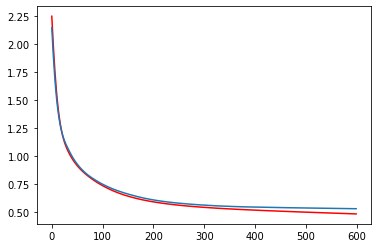

In [ ]:
plt.plot(train_losses, label='train-loss', color="red")
plt.plot(val_losses, label='val-loss')

Calculating the accuracy

In [ ]:
accuracy_train = accuracy_score(y_train.detach().numpy(), np.argmax(y_pred.detach().numpy(), axis=1))
print(accuracy_train)

accuracy_val = accuracy_score(y_val.detach().numpy(), np.argmax(pred_y_val.detach().numpy(), axis=1))
print(accuracy_val)

0.8035264483627204
0.7903682719546742


In [ ]:
cm = confusion_matrix(np.argmax(pred_y_val, axis=1), y_val.numpy())
cm

array([[ 32,   6,   0,   0,   0,   0],
       [  7, 131,  11,   1,   0,   0],
       [  0,  13, 102,  16,   1,   0],
       [  0,   0,  12,  13,   5,   0],
       [  0,   0,   0,   1,   1,   1],
       [  0,   0,   0,   0,   0,   0]])